<!--
clang-format off
-->

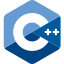
<br>

<div style="text-align:center; font-size:200%;">
 <b>The Curiously Recurring Template Pattern (CRTP)</b>
</div>
<br/>
<div style="text-align:center; font-size:120%;">Dr. Matthias Hölzl</div>
<br/>
<div style="text-align:center;">Coding-Akademie München</div>
<br/>
<!-- 05 The Curiously Recurring Template Pattern (CRTP).ipynb -->
<!-- slides/module_470_cpp_patterns/topic_210_crtp.cpp -->


# Das Curiously Recurring Template Pattern (CRTP)

- Das CRTP ist ein Idiom, das die "statische Vererbung" von Verhalten
  ermöglicht
- Die Basisklasse ist eine Template-Klasse, die von der abgeleiteten Klasse
  als Template-Parameter spezialisiert wird


### Zweck des Template Method Patterns

Definiere ein Verhalten oder einen Algorithmus, in dem bestimmte Schritte zur
Implementierung oder Modifikation in Unterklassen vorgesehen sind. Die
Unterklassen können individuelle Schritte, die vom Algorithmus ausgeführt
werden überschreiben, haben aber keinen Einfluss auf seine Gesamtstruktur.


### Motivation für das Template Method Pattern

- Eine Anwendung, die mit verschiedenen Arten von Dokumenten umgehen muss
- Gemeinsame Funktionalität in einer Basisklasse implementiert
- Unterklassen spezialisieren einzelne Schritte


### Klassendiagramm

<img src="img/template_method_example.svg"
     style="display:block;margin:auto;width:40%"/>

In [ ]:
#include <iostream>
#include <string>

In [ ]:
class Document {
public:
    virtual ~Document() = default;

    void Save() {
        std::cout << "Saving to existing file.\n";
        DoSave();
        std::cout << "Document saved.\n\n";
    }

    void SaveAs() {
        std::cout << "Asking user for file name.\n";
        DoSave();
        std::cout << "Document saved.\n\n";
    }

protected:
    virtual void DoSave() = 0;
};

In [ ]:
class TextDocument : public Document {
    void DoSave() override { std::cout << "-> Saving text document in DOCX format.\n"; }
};

In [ ]:
class SpreadsheetDocument : public Document {
    void DoSave() override { std::cout << "-> Saving spreadsheet in XLSX format.\n"; }
};

In [ ]:
SpreadsheetDocument spreadsheet;
spreadsheet.Save();
spreadsheet.SaveAs();

In [ ]:
TextDocument text;
text.Save();
text.SaveAs();


### Struktur des Template Method Patterns

<img src="img/pat_template_method.svg"
     style="display:block;margin:auto;width:40%"/>


## Implementierung mit Templates

In [ ]:
template <typename T>
class DocumentV1 {
public:
    void Save() {
        std::cout << "Saving to existing file.\n";
        T::DoSave();
        std::cout << "Document saved.\n\n";
    }

    void SaveAs() {
        std::cout << "Asking user for file name.\n";
        T::DoSave();
        std::cout << "Document saved.\n\n";
    }
};

In [ ]:
class TextDocumentV1 {
public:
    static void DoSave() { std::cout << "-> Saving text document in DOCX format.\n"; }
};

In [ ]:
class SpreadsheetDocumentV1 {
public:
    static void DoSave() { std::cout << "-> Saving spreadsheet in XLSX format.\n"; }
};


- Spezialisierte Funktionen müssen `static` sein und haben keinen Zugriff auf
  Objektdaten
- Wir können nicht mit `TextDocumentV1` und `SpreadsheetDocumentV1` arbeiten,
  ohne sie in ein `DocumentV1`-Objekt einzupacken

In [ ]:
DocumentV1<TextDocumentV1> textV1;
textV1.Save();

In [ ]:
DocumentV1<SpreadsheetDocumentV1> spreadsheetV1;
spreadsheetV1.Save();


# Implementierung mit CRTP

- "Oberklasse" `Base` bekommt "abgeleitete Klasse" `Derived` als Template-Parameter
- `Base` verwendet einen `static_cast`, um den `this`-Pointer in einen Pointer
  auf `Derived` zu konvertieren
- `Derived` erbt von `Base<Derived>`
- Wir erreichen den gleichen Effekt wie mit dem Template-Method Pattern,
  sparen aber einen virtuellen Dispatch

In [ ]:
template <typename Derived>
class DocumentV2 {
public:
    void Save() {
        std::cout << "Saving to existing file.\n";
        static_cast<Derived*>(this)->DoSave();
        std::cout << "Document saved.\n\n";
    }

    void SaveAs() {
        std::cout << "Asking user for file name.\n";
        static_cast<Derived*>(this)->DoSave();
        std::cout << "Document saved.\n\n";
    }
};

In [ ]:
class TextDocumentV2 : public DocumentV2<TextDocumentV2> {
public:
    void DoSave() { std::cout << "-> Saving text document in DOCX format.\n"; }
};

In [ ]:
class SpreadsheetDocumentV2 : public DocumentV2<SpreadsheetDocumentV2> {
public:
    void DoSave() { std::cout << "-> Saving spreadsheet in XLSX format.\n"; }
};


- Jetzt können wir direkt mit `TextDocumentV2` und `SpreadsheetDocumentV2` arbeiten
- `DoSave` ist eine normale Member-Funktion, die auf Objektdaten zugreifen kann

In [ ]:
TextDocumentV2 textV2;
textV2.Save();

In [ ]:
SpreadsheetDocumentV2 spreadsheetV2;
spreadsheetV2.Save();


## CRTP in der Standardbibliothek

- `std::enable_shared_from_this`
- `ranges::view_interface`


## Konsequenzen von CRTP

- Kein virtueller Dispatch
- Keine polymorphen Container möglich
- Kein dynamischer Austausch von Implementierungen möglich


## C++ 23

Statt

```cpp
template <class Derived>
struct Base { void Fun() { (static_cast<Derived*>(this))->Impl(); } };
```

kann die Basisklasse mit explizitem `this`-Parameter definiert werden:

```cpp
struct Base { void Fun(this auto&& self) { self.Impl(); } };
```